In [70]:
import torchvision
import numpy as np
import TensionFlow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
import random
import math
import importlib

In [98]:
importlib.reload(tf)

<module 'TensionFlow' from '/media/fakhir/SSD/AIExp/AutoGrad/Compt-Graphs-Gradients/TensionFlow.py'>

In [30]:
train_data = torchvision.datasets.MNIST('data/', train=True)
test_data = torchvision.datasets.MNIST('data/', train=False)

In [31]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test)

**Forward Pass**

In [99]:
#defining model
f_in = 28*28
f_out = 10
# h_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(f_in, f_out)))
# b_layer = tf.Neuron(np.random.uniform(low=-np.sqrt(1/f_in), high=np.sqrt(1/f_in), size=(1 , f_out)))

h_layer = tf.LinearLayer(f_in, f_out)
b_layer = tf.LinearLayer(1, f_out)

In [100]:
lr = 1e-5

In [101]:
lossi = []
test_lossi = []

In [102]:
epochs = 3

In [103]:
batch_size = 256

In [104]:
for e in tqdm(range(epochs)):
    for i in range(0,len(train_data), batch_size):
#         print(train_data.data[i:i+batch_size].shape)
        current_batch_size = train_data.data[i:i+batch_size].shape[0]
        inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = train_data.targets[i:i+batch_size]    
        
        out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
        out_soft = tf.Softmax(out)
        
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
        
#         loss = -(out_soft * oh_label).sum().log().sum(0)
        loss = tf.CrossEntropy(out_soft,oh_label)
        
        loss.backward()
        h_layer.value -= h_layer.grad * lr
        b_layer.value -= b_layer.grad.sum(0) * lr
        lossi.append(loss.value[0][0])
        loss.backward_zero_grad()
    
    for i in range(0,len(test_data), batch_size):
        current_batch_size = test_data.data[i:i+batch_size].shape[0]
        
        inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = test_data.targets[i:i+batch_size]    
        
        out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
        out_soft = tf.Softmax(out)
        
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
#         loss = -(out_soft * oh_label).sum().log().sum(0)
        loss = tf.CrossEntropy(out_soft,oh_label)
        
        test_lossi.append(loss.value[0][0])

100%|██████████| 3/3 [00:38<00:00, 12.92s/it]


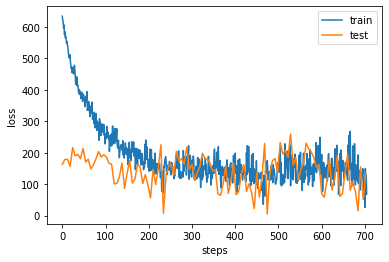

In [105]:
plt.plot(lossi[:])
x = list(range(0,len(lossi), math.ceil(len(lossi)/len(test_lossi))))
plt.plot(x, test_lossi[:len(x)])
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [93]:
#accuracy
correct = 0
for i in range(0,len(test_data)//batch_size):
    current_batch_size = test_data.data[i:i+batch_size].shape[0]
    inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = test_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
    out_soft = tf.Softmax(out)
    correct += (out_soft.argmax(1) == label.numpy()).sum()
#     loss = -(out_soft * oh_label).sum().log().sum(0)
#     test_lossi.append(loss.value[0][0])

In [94]:
correct/ len(test_data)

0.8312

In [95]:
#accuracy
correct = 0
for i in range(0,len(train_data)//batch_size):
    current_batch_size = train_data.data[i:i+batch_size].shape[0]
    inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = train_data.targets[i:i+batch_size]    

    out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((current_batch_size,1))) @ b_layer)
    out_soft = tf.Softmax(out)
    correct += (out_soft.argmax(1) == label.numpy()).sum()
#     loss = -(out_soft * oh_label).sum().log().sum(0)
#     test_lossi.append(loss.value[0][0])

In [96]:
correct/ len(train_data)

0.8567166666666667

Pred: 5 grad: None, label: 5


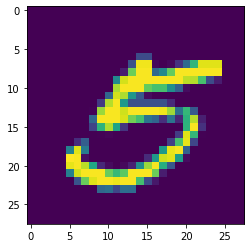

In [97]:
i = random.randint(0,len(test_data))
#inference
inp = test_data.data[i].reshape(1,28*28) / 255
label = test_data.targets[i]    

out = (tf.Neuron(inp.numpy()) @ h_layer) + (tf.Neuron(np.ones((1,1))) @ b_layer)
out_soft = tf.Softmax(out)
print(f'Pred: {out_soft.argmax()}, label: {label}')
plt.imshow(test_data.data[i])
